In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import numpy as np
from matplotlib_venn import venn2

In [2]:
threshold="0.571461" #where to split gene set into 2 groups
Categories=["BioProc", "MolecFunc", "CellComp"] #enriched terms to plot
cat_to_full = {'MolecFunc': 'Molecular Function', 'CellComp': 'Cellular Component', 'BioProc': 'Biological Process'}
positive_color = sns.color_palette('colorblind')[0]
uncertain_positive_color = sns.color_palette('colorblind')[2]
uncertain_negative_color = sns.color_palette('colorblind')[3]

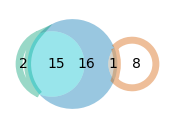

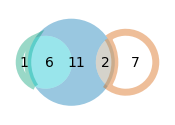

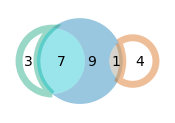

In [3]:
# Venn diagram
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles


for i, Category in enumerate(Categories):
    #positives
    filename_positive=Category+"_positives.txt"
    df_positive=pd.read_csv(filename_positive, sep="\t")
    
    #uncertain split
    filename_uncertain_above=f"{Category}_above_{threshold}.txt"
    df_above=pd.read_csv(filename_uncertain_above, sep="\t")
    
    filename_uncertain_below=f"{Category}_below_{threshold}.txt"
    df_below=pd.read_csv(filename_uncertain_below, sep="\t")
    
    set_pos = set(df_positive['Term'].to_list())
    set_pred_pos = set(df_above['Term'].to_list())
    set_pred_neg = set(df_below['Term'].to_list())
    
    set_pos_unique = set_pos.difference(set_pred_pos).difference(set_pred_neg)  # A
    set_pred_pos_unique = set_pred_pos.difference(set_pos).difference(set_pred_neg)  # B
    set_pred_neg_unique = set_pred_neg.difference(set_pos).difference(set_pred_pos)  # C
    set_pos_and_pred_pos = set_pos & set_pred_pos  # A ∩ B
    set_pos_and_pred_neg = set_pos & set_pred_neg  # A ∩ C
    set_pred_pos_and_pred_neg = set_pred_pos & set_pred_neg  # B ∩ C
    set_all = set_pos & set_pred_pos & set_pred_neg  # A ∩ B ∩ C
    
    
    plt.figure(figsize=(2, 2))
    # (Abc, aBc, ABc, abC, AbC, aBC, ABC)
    v = venn3(subsets=(
        len(set_pos_unique),  
        len(set_pred_pos_unique),  
        len(set_pos_and_pred_pos),  
        len(set_pred_neg_unique),  
        len(set_pos_and_pred_neg),  
        len(set_pred_pos_and_pred_neg),  
        len(set_all),),
              set_labels = ('', '', ''), 
              set_colors=[positive_color, uncertain_positive_color, uncertain_negative_color], )
    lbl = v.get_label_by_id("B")
    # x, y = lbl.get_position()
    # lbl.set_position((x-0.2, y+0.95))  # Or whatever
    v.get_patch_by_id('B').set_edgecolor(uncertain_positive_color)
    v.get_patch_by_id('B').set_facecolor('white')
    v.get_patch_by_id('B').set_linewidth(5)
    
    lbl = v.get_label_by_id("C")
    # x, y = lbl.get_position()
    # lbl.set_position((x+0.25, y+0.6))  # Or whatever
    v.get_patch_by_id('001').set_edgecolor(uncertain_negative_color)
    v.get_patch_by_id('001').set_facecolor('white')
    v.get_patch_by_id('001').set_facecolor('white')
    v.get_patch_by_id('001').set_linewidth(5)
    
    plt.savefig(f"Fig3_venn_{Category}v2.svg", dpi=250, bbox_inches="tight")
    plt.show()


In [4]:
# Fisher's exact test
Categories=["BioProc", "MolecFunc", "CellComp"] #enriched terms to plot

for i, Category in enumerate(Categories):
    #positives
    filename_positive=Category+"_positives.txt"
    df_positive=pd.read_csv(filename_positive, sep="\t")
    
    #uncertain split
    filename_uncertain_above=f"{Category}_above_{threshold}.txt"
    df_above=pd.read_csv(filename_uncertain_above, sep="\t")
    
    filename_uncertain_below=f"{Category}_below_{threshold}.txt"
    df_below=pd.read_csv(filename_uncertain_below, sep="\t")
    
    from scipy.stats import fisher_exact

    for setting in ['positive', 'negative']:
        set_a = set(df_positive['Term'].to_list())
        if setting == 'positive':
            set_b = set(df_above['Term'].to_list())
        elif setting == 'negative':
            set_b = set(df_below['Term'].to_list())
        
        # Define the contingency table
        a = len(set_a & set_b)  # Overlap of Set A and Set B
        b = len(set_a) - a      # Genes in Set A but not in Set B
        c = len(set_b) - a      # Genes in Set B but not in Set A
        d = len(set_a | set_b)  # Remaining genes not in either Set A or Set B
        
        # Run Fisher's Exact Test
        oddsratio, p_value = fisher_exact([[a, b], [c, d]])
        print(f"{Category} {setting} Odds Ratio: {oddsratio:4f}, P-value: {p_value:4f}")


BioProc positive Odds Ratio: 15.000000, P-value: 0.000138
BioProc negative Odds Ratio: 0.161290, P-value: 0.077973
MolecFunc positive Odds Ratio: 9.230769, P-value: 0.039501
MolecFunc negative Odds Ratio: 0.436975, P-value: 0.458248
CellComp positive Odds Ratio: 4.666667, P-value: 0.066309
CellComp negative Odds Ratio: 0.328125, P-value: 0.632289


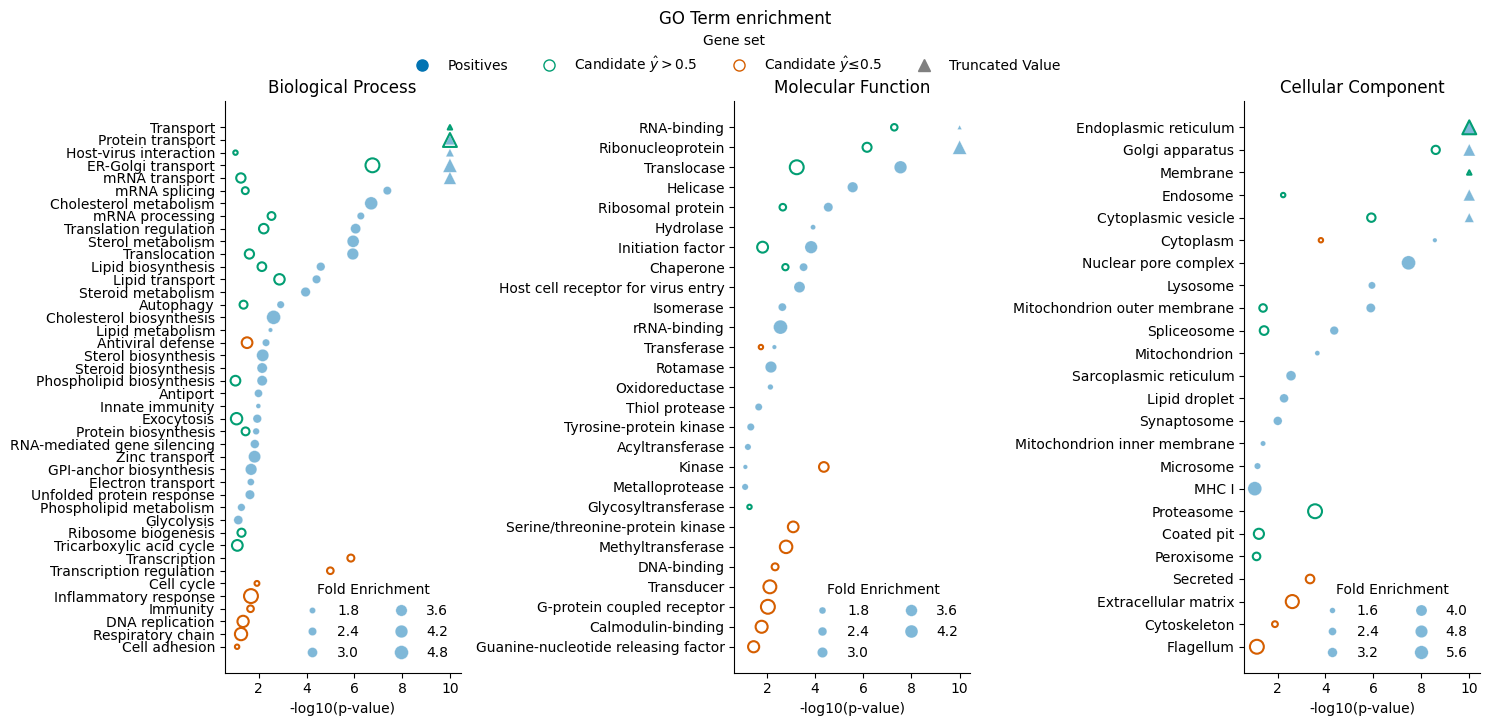

In [5]:
# Plot p-values for each term
plt.figure(figsize=(15, 7))
trunc=10


for i, Category in enumerate(Categories):
    #positives
    filename_positive=Category+"_positives.txt"
    df_positive=pd.read_csv(filename_positive, sep="\t")
    df_positive['Term'] = df_positive['Term'].apply(lambda x: x.split('~')[1])
    df_positive["-log10(p-value)"]=np.log10(df_positive["PValue"])*(-1)
    df_positive_range=df_positive[df_positive["-log10(p-value)"]<trunc]
    df_positive_trunc=df_positive[df_positive["-log10(p-value)"]>=trunc]
    
    #uncertain split
    filename_uncertain_above=f"{Category}_above_{threshold}.txt"
    df_above=pd.read_csv(filename_uncertain_above, sep="\t")
    df_above['Term'] = df_above['Term'].apply(lambda x: x.split('~')[1])
    df_above["-log10(p-value)"]=np.log10(df_above["PValue"])*(-1)
    df_above_range=df_above[df_above["-log10(p-value)"]<trunc]
    df_above_trunc=df_above[df_above["-log10(p-value)"]>=trunc]
    
    filename_uncertain_below=f"{Category}_below_{threshold}.txt"
    df_below=pd.read_csv(filename_uncertain_below, sep="\t")
    df_below['Term'] = df_below['Term'].apply(lambda x: x.split('~')[1])
    df_below["-log10(p-value)"]=np.log10(df_below["PValue"])*(-1)
    df_below_range=df_below[df_below["-log10(p-value)"]<trunc]
    df_below_trunc=df_below[df_below["-log10(p-value)"]>=trunc]
    
    size_scale=(10,100)
    
    # fig=plt.figure(figsize=(5,10))
    plt.subplot(1, 3, i+1)
    
    sns_positive_trunc= sns.scatterplot(data=df_positive_trunc, y="Term", x=[trunc]*len(df_positive_trunc), size="Fold Enrichment", alpha=0.5, color=positive_color, sizes=size_scale, marker="^", legend=False)
    # sns_positive= sns.scatterplot(data=df_positive_range, y="Term", x="-log10(p-value)", size="Fold Enrichment", alpha=0.5, color=positive_color, sizes=size_scale, legend=i==2)
    sns_positive= sns.scatterplot(data=df_positive_range, y="Term", x="-log10(p-value)", size="Fold Enrichment", alpha=0.5, color=positive_color, sizes=size_scale, legend=True)
    sns_above= sns.scatterplot(data=df_above_trunc, y="Term", x=[trunc]*len(df_above_trunc), size="Fold Enrichment", edgecolor=uncertain_positive_color, facecolor="none", linewidth=1.5, sizes=size_scale, legend=False, marker="^")
    sns_above= sns.scatterplot(data=df_above_range, y="Term", x="-log10(p-value)", size="Fold Enrichment", edgecolor=uncertain_positive_color, facecolor="none", linewidth=1.5, sizes=size_scale, legend=False)
    sns_below= sns.scatterplot(data=df_below_trunc, y="Term", x=[trunc]*len(df_below_trunc), size="Fold Enrichment", edgecolor=uncertain_negative_color, facecolor="none", linewidth=1.5, sizes=size_scale, legend=False, marker="^")
    sns_below= sns.scatterplot(data=df_below_range, y="Term", x="-log10(p-value)", size="Fold Enrichment", edgecolor=uncertain_negative_color, facecolor="none", linewidth=1.5, sizes=size_scale, legend=False)
    
    plt.ylabel('')

    if i == 1:
        legend_elements = [Line2D([0], [0], marker='o', color=positive_color,lw=0, label='Positives', markerfacecolor=positive_color, markersize=8),
                          Line2D([0], [0], marker='o', color=uncertain_positive_color,lw=0, label=r'Candidate $\hat{y}>0.5$', markerfacecolor='none', markersize=8),
                          Line2D([0], [0], marker='o', color=uncertain_negative_color,lw=0, label=r'Candidate $\hat{y}≤0.5$', markerfacecolor='none', markersize=8),
                          Line2D([0], [0], marker='^', color='grey',lw=0, label='Truncated Value', markerfacecolor='grey', markersize=8)]
        legend1= plt.legend(title="Gene set", handles=legend_elements, bbox_to_anchor=(0., 1.14),loc="upper center", ncols=5, frameon=False)
        plt.gca().add_artist(legend1)
       
    plt.legend(title="Fold Enrichment", bbox_to_anchor=(1.,0),loc="lower right", frameon=False, ncols=2)

    plt.title(f"{cat_to_full[Category]}")
    sns.despine()
plt.suptitle('GO Term enrichment', y=1.03)
plt.tight_layout()
plt.savefig(f"GOv2.pdf", dpi=250, bbox_inches="tight")
plt.savefig(f"GOv2.svg", dpi=250, bbox_inches="tight")
plt.show()